In [1]:
import mxnet as mx
from mxnet import init, gluon, nd, autograd, image
from mxnet.gluon.model_zoo import vision
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from time import time
%matplotlib inline
ctx = mx.gpu()
data_dir = '/home/sinyer/python/data/hotdog'

In [2]:
def load_data(route = data_dir):
    train_imgs = gluon.data.vision.ImageFolderDataset(route+'/train',
        transform=lambda X, y: augment(X, y, train_augs))
    test_imgs = gluon.data.vision.ImageFolderDataset(route+'/test',
        transform=lambda X, y: augment(X, y, test_augs))
    return train_imgs, test_imgs

def augment(data, label, augs):
    data = data.astype('float32')
    for aug in augs:
        data = aug(data)
    data = nd.transpose(data, (2,0,1))
    return data, nd.array([label]).asscalar().astype('float32')

def accuracy(output, label):
    return nd.mean(output.argmax(axis=1)==label).asscalar()

def evaluate_accuracy(data_iterator, net, ctx):
    acc = 0.
    for data, label in data_iterator:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        acc += accuracy(output, label)
    return acc / len(data_iterator)

In [3]:
batch_size = 32
train_augs = [image.HorizontalFlipAug(.5),image.RandomCropAug((224,224))]
test_augs = [image.CenterCropAug((224,224))]

train_imgs, test_imgs = load_data()
train_data = gluon.data.DataLoader(train_imgs, batch_size, shuffle=True)
test_data = gluon.data.DataLoader(test_imgs, batch_size)

In [4]:
pretrained_net = vision.resnet18_v2(pretrained=True)

net = vision.resnet18_v2(classes=2)
net.features = pretrained_net.features
net.output.initialize(init.Xavier())

net.collect_params().reset_ctx(ctx)
net.hybridize()
loss = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01, 'wd': 1e-3})

0 loss:0.2783 tracc:0.8795 teacc:0.9250 time:16.309
1 loss:0.1476 tracc:0.9415 teacc:0.9500 time:14.186
2 loss:0.0914 tracc:0.9673 teacc:0.9475 time:14.444
3 loss:0.0917 tracc:0.9678 teacc:0.9600 time:14.348
4 loss:0.0679 tracc:0.9757 teacc:0.9513 time:14.306
5 loss:0.0524 tracc:0.9812 teacc:0.9663 time:14.883
6 loss:0.0474 tracc:0.9821 teacc:0.9600 time:14.090
7 loss:0.0347 tracc:0.9901 teacc:0.9587 time:13.971
8 loss:0.0453 tracc:0.9851 teacc:0.9625 time:13.843
9 loss:0.0284 tracc:0.9931 teacc:0.9513 time:13.743
tracc:0.993056 teacc:0.951250


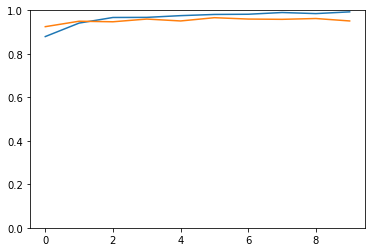

In [5]:
epochs = 10

a = []
b = []
for epoch in range(epochs):
    train_loss = 0.
    train_acc = 0.
    start = time()
    for data, label in train_data:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            l = loss(output, label)
        l.backward()
        trainer.step(batch_size)
        train_loss = train_loss + nd.mean(l).asscalar()
        train_acc = train_acc + accuracy(output, label)
    test_acc = evaluate_accuracy(test_data, net, ctx)
    
    if epoch%1 == 0:
        print(epoch, 'loss:%.4f tracc:%.4f teacc:%.4f time:%.3f'%(
            train_loss/len(train_data), train_acc/len(train_data), test_acc, time()-start)) 
    a.append(train_acc/len(train_data))
    b.append(test_acc)

print('tracc:%f teacc:%f'%(train_acc/len(train_data), test_acc))
plt.plot(np.arange(epochs), a, np.arange(epochs), b)
plt.ylim(0,1)
plt.show()

In [8]:
def classify_hotdog(net, fname):
    with open(fname, 'rb') as f:
        img = image.imdecode(f.read())
    test_augs = [image.CenterCropAug((224,224))]
    data, _ = augment(img, -1, test_augs)
    data = data.expand_dims(axis=0)
    out = nd.SoftmaxActivation(net(data.as_in_context(ctx)))
    pred = int(nd.argmax(out, axis=1).asscalar())
    prob = out[0][pred].asscalar()
    label = train_imgs.synsets
    return 'prob=%f, %s'%(prob, label[pred])

'prob=0.998356, hotdog'

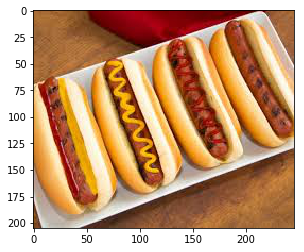

In [9]:
img = image.imread('test.jpeg')
plt.imshow(img.asnumpy())
classify_hotdog(net, 'test.jpeg')